In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from ripser import ripser
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

Baseline Acc: 0.575 ± 0.022
Betti-only Acc: 0.593 ± 0.015
Acc t-test: t=3.557, p=0.006

Baseline AUC: 0.602 ± 0.018
Betti-only AUC: 0.630 ± 0.020
AUC t-test: t=7.437, p=0.000


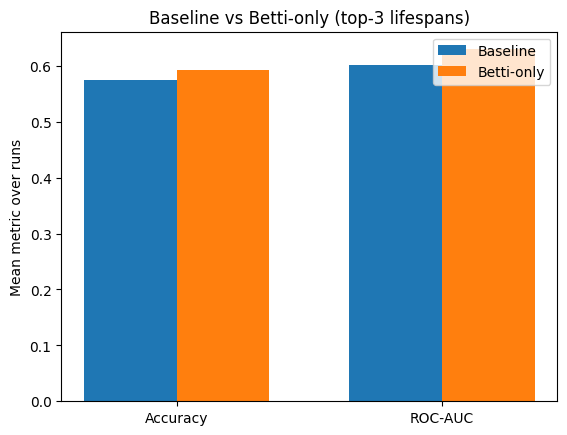

In [6]:
ticker = 'SPY'
data = yf.download(ticker, start='2018-01-01', end='2025-05-01', progress=False)
prices = data['Close'].dropna().to_numpy().flatten()
returns = np.diff(prices) / prices[:-1]
abs_returns = np.abs(returns)
vol_threshold = np.median(abs_returns)
window_size = 90
horizon = 1
step = 1
n_windows = (len(returns) - window_size - horizon + 1) // step

X_feat = []
y = []
for i in range(n_windows):
    window = returns[i : i + window_size]
    future_ret = returns[i + window_size]
    label = int(abs(future_ret) > vol_threshold)
    tech_mean = window.mean()
    tech_std  = window.std()
    emb = np.vstack([window[:-1], window[1:]]).T
    dgms = ripser(emb, maxdim=1)['dgms']
    tda_feats = []
    for diag in dgms:
        ls = diag[:,1] - diag[:,0]
        if not np.all(np.isfinite(ls)):
            finite = ls[np.isfinite(ls)]
            ls = np.where(np.isfinite(ls), ls, finite.max() if finite.size else 0.0)
        top3 = np.pad(np.sort(ls)[::-1], (0, 3 - min(3, len(ls))), 'constant')[:3]
        tda_feats.extend(top3)
    X_feat.append([tech_mean, tech_std] + tda_feats)
    y.append(label)

cols = ['mean_ret','std_ret',
        'H0_l1','H0_l2','H0_l3',
        'H1_l1','H1_l2','H1_l3']
df = pd.DataFrame(X_feat, columns=cols)
df['label'] = y
runs = 10
acc_base, acc_tda = [], []
auc_base, auc_tda = [], []

for seed in range(runs):
    X_train, X_test, y_train, y_test = train_test_split(df[cols], df['label'], test_size=0.3,random_state=seed, stratify=df['label'])
    # Baseline
    base = RandomForestClassifier(random_state=seed)
    base.fit(X_train[['mean_ret','std_ret']], y_train)
    pred_b = base.predict(X_test[['mean_ret','std_ret']])
    prob_b = base.predict_proba(X_test[['mean_ret','std_ret']])[:,1]
    acc_base.append(accuracy_score(y_test, pred_b))
    auc_base.append(roc_auc_score(y_test, prob_b))
    # Betti-only
    tda = RandomForestClassifier(random_state=seed)
    tda.fit(X_train[['mean_ret','std_ret'] + cols[2:]], y_train)
    pred_t = tda.predict(X_test[['mean_ret','std_ret'] + cols[2:]])
    prob_t = tda.predict_proba(X_test[['mean_ret','std_ret'] + cols[2:]])[:,1]
    acc_tda.append(accuracy_score(y_test, pred_t))
    auc_tda.append(roc_auc_score(y_test, prob_t))

t_acc, p_acc = ttest_rel(acc_tda, acc_base)
t_auc, p_auc = ttest_rel(auc_tda, auc_base)

print(f"Baseline Acc: {np.mean(acc_base):.3f} ± {np.std(acc_base):.3f}")
print(f"Betti-only Acc: {np.mean(acc_tda):.3f} ± {np.std(acc_tda):.3f}")
print(f"Acc t-test: t={t_acc:.3f}, p={p_acc:.3f}\n")
print(f"Baseline AUC: {np.mean(auc_base):.3f} ± {np.std(auc_base):.3f}")
print(f"Betti-only AUC: {np.mean(auc_tda):.3f} ± {np.std(auc_tda):.3f}")
print(f"AUC t-test: t={t_auc:.3f}, p={p_auc:.3f}")

labels = ['Accuracy', 'ROC-AUC']
means_base = [np.mean(acc_base), np.mean(auc_base)]
means_tda  = [np.mean(acc_tda), np.mean(auc_tda)]

x = np.arange(len(labels))
width = 0.35
plt.figure()
plt.bar(x - width/2, means_base, width, label='Baseline')
plt.bar(x + width/2, means_tda, width, label='Betti-only')
plt.xticks(x, labels)
plt.ylabel('Mean metric over runs')
plt.legend()
plt.title('Baseline vs Betti-only (top-3 lifespans)')
plt.show()